<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 100px">

# Capstone Project: Classifying Logistics Research Papers
## Part 3 : EDA

---

 [Part 1: Get Text](01.Get_Text.ipynb) | [Part 2: Add Label](02.Add_Label.ipynb) | **Part 3: EDA** | [Part 4: Gridsearch Classification](04.Gridsearch_Classification.ipynb) | [Part 5: Neural Network Classification](05.NeuralNet_Classification.ipynb) | [Part 6: Model Evaluation](06.Model_Evaluation.ipynb) | [Part 7: Final Model](07.Final_Model.ipynb) 

---

### Introduction
This notebook provides insights and analyzes data behaviors from research papers as follows:

- **Tokenizer Comparison**: Compare tokenization results from three engines: **Newmm**, **Deepcut**, and **WangchanBERTa (pretrained)**.
- **Content length** : Analyze the text length from abstracts and full papers.
- **Word count** : Examine the word count from abstracts and full papers to aid in selecting features for model tuning in the next steps.
- **Category Distribution** : Display the number of research papers in each category.
- **Top words** : Identify the most frequently occurring words in the research papers.
- **Important words by category** : Highlight the key words for each category and compare their significance across other categories.

### Import Library

In [91]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from wordcloud import WordCloud
import re

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words, thai_stopwords
from pythainlp.util import dict_trie

import deepcut
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [92]:
df = pd.read_csv('../data/reseacrh_label_added.csv')
df.head()

project  \
0  การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...   
1  การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...   
2  การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...   
3  แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...   
4      การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม   

                                            abstract  \
0  ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...   
1  งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...   
2  ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...   
3  การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...   
4  จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...   

                                             content  \
0  การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...   
1  การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...   
2  การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...   
3  แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...   
4  การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม ...   

                                category  category_id  
0  Import-Export and International Trade            5  
1                            Procurement            0  
2             Logistics and Distribution            3  
3                            Procurement            0  
4        Demand Planning and Forecasting            4

In [93]:
df.shape

(340, 5)

In [94]:
# remove special charecters keep only and replace NaN or non-string values with empty string before applying the regex
df['content'] = df['content'].apply(lambda x: re.sub(r'[^A-Za-z0-9\sก-ฮะ-์]', '', str(x)) if isinstance(x, str) else '')

---

### Word Tokenization

in this step, I will explore three engines to tokenize text in a list of strings and select the engine that performs the best for future processing.

**Options for engine**
1. **newmm** (default) is a dictionary-based approach that performs maximum matching, constrained by Thai Character Cluster (TCC) boundaries with improved TCC rules.

2. [**DeepCut**](https://github.com/rkcosmos/deepcut)
is a learning-based tokenization engine that leverages deep learning to segment Thai text.
3. [**WangchanBERTa**](https://huggingface.co/airesearch/wangchanberta-base-att-spm-uncased)
is a pre-trained transformer-based language model designed specifically for Thai text. It builds upon the BERT architecture and incorporates innovations and optimizations tailored for the Thai language, making it a powerful tool for various Natural Language Processing (NLP) tasks in Thai.

In [98]:
# Checking tokenizer performance using the first 5 abstracts as sample texts
sample = ' '.join(df['abstract'][:5].to_list())

In [99]:
# Add custom word to keep from 5 sample abstract
added_words = ['การนำเข้า', 'ฐานนิยม', 'คราฟท์', 'แนวทาง', 'ผู้ส่งมอบ', 'โซ่อุปทาน', 'ปัจจัยรอง', 
               'การส่งมอบ', 'รถขนส่ง', 'นำไปใช้งาน', 'อย่างถูกต้อง', 'การขับรถ', 'ที่เกี่ยวข้อง', 
               'ในการปฏิบัติงาน', 'พนักงานขับรถ', 'สิ่งสำคัญ', 'ขั้นตอน', 'ที่ชัดเจน', 'การไหล', 'ยอดขาย', 
              'การจัดทำ', 'คราฟท์เบียร์', 'ฝึกสหกิจ', 'อย่างก้าวกระโดด','การจัดซื้อจัดหา','กระบวนการ',
               'แบบประเมิน','เก็บข้อมูล','อย่างชัดเจน','การดำเนินการ','การส่งเสริม','ถังดับเพลิง','แนวทาง', 'โลจิสติคส์']

# Merge custom words with Thai dictionary words
custom_words = set(thai_words()).union(added_words)
custom_trie = dict_trie(custom_words)  # Create a trie from the custom dictionary

In [100]:
newmm_tokenize = word_tokenize(sample,custom_dict = custom_trie, engine="newmm")

In [101]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

deepcut_tokenize  = word_tokenize(sample,custom_dict = custom_trie, engine="deepcut")

226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


In [102]:
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
model = AutoModelForMaskedLM.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

wangchan_tokenize = tokenizer.tokenize(sample)

In [103]:
# Compare each tokenizer against others
all_tokenized = {
    "newmm": set(newmm_tokenize),
    "deepcut": set(deepcut_tokenize),
    "wangchan": set(wangchan_tokenize),
}

print('Words in newmm but not tokenized in other engines:')
print(', '.join(all_tokenized["newmm"] - (all_tokenized["deepcut"] | all_tokenized["wangchan"])))
print()

print('Words in deepcut but not tokenized in other engines:')
print(', '.join(all_tokenized["deepcut"] - (all_tokenized["newmm"] | all_tokenized["wangchan"])))
print()

print('Words in WangchanBERTa but not tokenized in other engines:')
print(', '.join(all_tokenized["wangchan"] - (all_tokenized["newmm"] | all_tokenized["deepcut"])))

Words in newmm but not tokenized in other engines:
เกื้อหนุน, การนำเข้า, หาก, มาก, การทำงาน, เติบโต, ตามที่, ปฏิบัติหน้าที่, อินโฟกราฟิกส์, (Supplier), โร, มีประสิทธิภาพ, ที่จะ, สำคัญ, ปัจจุบัน, ใบกำกับภาษี, การปรับปรุง, ข้อกำหนด, แนว, แบบประเมิน, การผลิต, นอกจากนี้, ดำเนินงาน, อย่างก้าวกระโดด, จัดทำ, จำเป็น, เป็นไป, อุบัติภัย, จากนั้น, ทำการ, อย่างถูกต้อง, รถขนส่ง, บริษัทผู้ผลิต, อยู่, คุณภาพ, ทำให้, หน้าที่, เครื่องหมาย, เนื่องจาก, สูญเสีย, เพลิง, เปลี่ยนแปลง, ความคลาดเคลื่อน, ทำงาน, ก็, การพิจารณา, นา, ปัจจัยหลัก, แผนภูมิ, ตามลำดับ, ปรับปรุงแก้ไข, ที่เกี่ยวข้อง, ค่าสัมบูรณ์, ไทย, ความสำคัญ, การคำนวณ, ปัจจัยรอง, รูปแบบ, ประสิทธิภาพ, มีความสำคัญ, สายไฟฟ้า, เชื้อไวรัส, รวมถึง, วัตถุประสงค์, ซึ่ง, ทางการ, ใบแจ้งหนี้, แบบทดสอบ, สร้างความสัมพันธ์, กำจัด, หลาย, ความยุ่งยาก, ภาค, คุณค่า, เพิ่ม, ช่วย, กรณี, ขายของ, ประยุกต์ใช้, ความปลอดภัย, ขีดความสามารถ, ด้าน, การไหล, คราฟท์เบียร์, บริเวณ, ในการปฏิบัติงาน, ความร่วมมือ, การส่งมอบ, ฝักบัว, ก๊อกน้ำ, ให้กำลังใจ, สร้าง, ดับ, ฐานนิยม, การจัดทำ, ผ

**Deepcut performs poorly, while Newmm and WangchanBERTa perform well. Therefore, I will select Newmm and WangchanBERTa as the tokenizers for model tuning.**

---

### Exploratory Data Analysis

This step will analyze the length and word count of the abstracts and full texts in the papers to aid in deciding whether to use abstracts or full texts as features for model tuning.

In [108]:
def tokenizer(text):
    return len(word_tokenize(text,custom_dict = custom_trie, engine="newmm"))

In [109]:
df['content_length'] = df['content'].apply(lambda x: len(x))    
df['abstract_length'] = df['abstract'].apply(lambda x: len(x))    

In [110]:
df['content_word_count'] = df['content'].apply(tokenizer)     
df['abstract_word_count'] = df['abstract'].apply(tokenizer)     

In [111]:
print("Text Length  Comparizon:")
print('Content Length:', int(df['content_length'].mean()))
print('Abstract Length:', int(df['abstract_length'].mean()))
print()
print("Word Count  Comparizon:")
print('Content Word Count:', int(df['content_word_count'].mean()))
print('Abstract Word Count:', int(df['abstract_word_count'].mean()))

Text Length  Comparizon:
Content Length: 14279
Abstract Length: 1232

Word Count  Comparizon:
Content Word Count: 3336
Abstract Word Count: 281


In [112]:
# Set the Thai font (you can replace 'TH SarabunPSK' with any Thai font installed on your system)
matplotlib.rcParams['font.family'] = 'TH SarabunPSK'

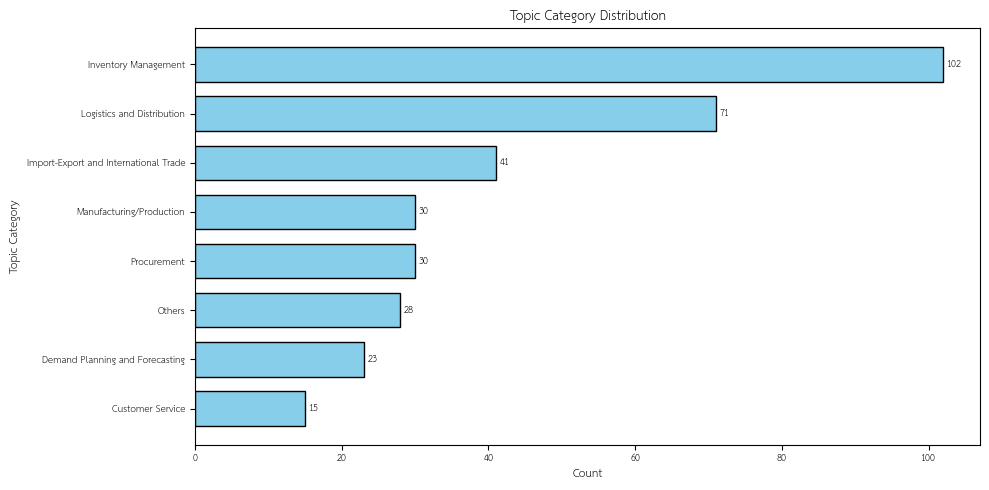

In [113]:
# Create a bar chart
topic_counts = df['category'].value_counts().sort_values(ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(topic_counts.index, topic_counts.values, color='skyblue', edgecolor='black', height=0.7)

# Add values to the bars, with dynamic positioning to avoid overlap
for bar in bars:
    bar_width = bar.get_width()
    bar_y = bar.get_y() + bar.get_height() / 2
    # Adjust the position of the labels to avoid overlap
    ax.text(bar_width + 0.5, bar_y, str(bar_width),
            va='center', ha='left', fontsize=10, color='black')

# Customize the chart
ax.set_title('Topic Category Distribution', fontsize=14)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Topic Category', fontsize=12)
ax.set_xlim(0, max(topic_counts.values) + 5)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# plot save
plt.savefig('../images/category_distribution.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()

In [114]:
# Save cleaned dataframe to next process
df.to_csv('../data/cleaned_text.csv', index=False)

---

### Check Common word in each topic category

In [117]:
thai_stopwords_list = ' '.join(thai_stopwords()).split()

In [118]:
# Define a custom tokenizer function that only matches Thai alphabet characters
def clean_tokenizer(text):
    thai_english_text = re.sub(r'[^ก-๙ก-ฮa-zA-Z\s]', '', text)
    words_list = word_tokenize(thai_english_text, custom_dict=custom_trie, engine="newmm")
    words_list_cleaned = [word.strip() for word in words_list if word not in thai_stopwords_list]
    return words_list_cleaned

In [119]:
# Initialize the CountVectorizer with a custom token_pattern and stop words list
cvec = TfidfVectorizer(
    tokenizer=clean_tokenizer,  # Custom tokenizer
    token_pattern=None
)

# Fit and transform the text data
X = cvec.fit_transform(df['content']).todense()  # Fitting and transforming
df_X = pd.DataFrame(X, columns=cvec.get_feature_names_out())  # Create DataFrame with words as columns
df_X.head()

df_X_pc = pd.concat([df['category'], df_X.drop(columns= '')], axis = 1)
df_X_pc = df_X_pc.loc[:, ~df_X_pc.columns.duplicated()].groupby('category').sum()
df_X_pc.T.head()

category        Customer Service  Demand Planning and Forecasting  \
a                       0.139488                         0.176885   
aa                      0.000000                         0.000000   
aaa                     0.000000                         0.000000   
aaltonen                0.000000                         0.000000   
aaoptimization          0.000000                         0.000000   

category        Import-Export and International Trade  Inventory Management  \
a                                            0.062046              0.592296   
aa                                           0.000000              0.080200   
aaa                                          0.000000              0.098536   
aaltonen                                     0.000000              0.014038   
aaoptimization                               0.000000              0.011886   

category        Logistics and Distribution  Manufacturing/Production  \
a                                 0.193988                  0.055252   
aa                                0.025767                  0.000000   
aaa                               0.000000                  0.000000   
aaltonen                          0.000000                  0.000000   
aaoptimization                    0.000000                  0.000000   

category          Others  Procurement  
a               0.086617     0.118038  
aa              0.000000     0.000000  
aaa             0.000000     0.000000  
aaltonen        0.000000     0.000000  
aaoptimization  0.000000     0.000000

In [120]:
# 20 Top Words
df_top_words = df_X_pc.sum().sort_values()[-20:]

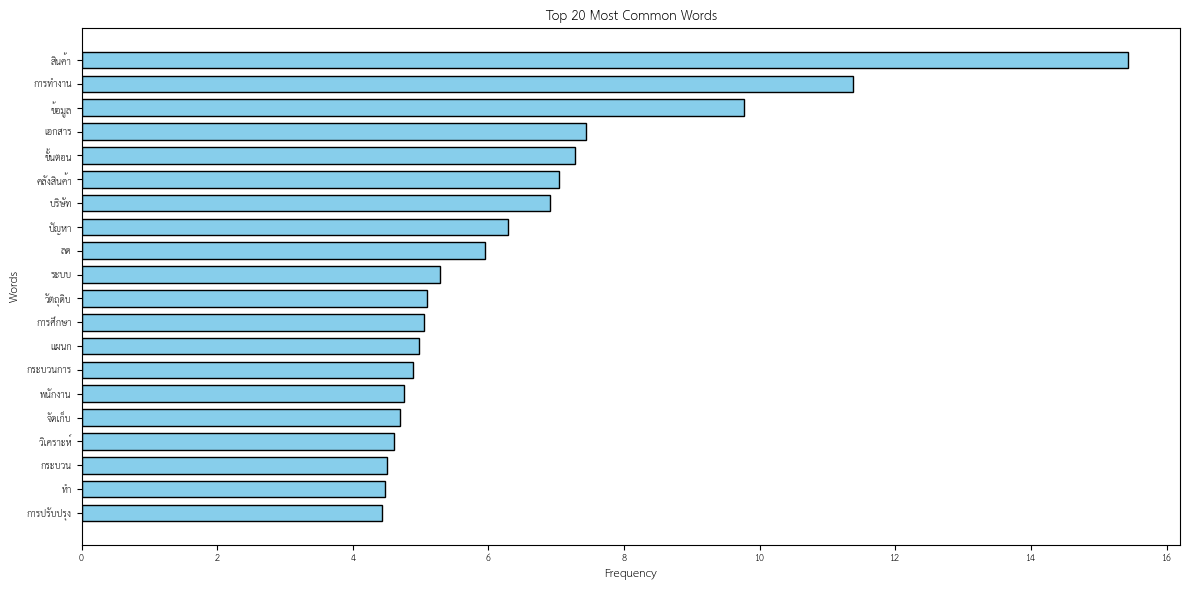

In [121]:
# Create a figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Generate the horizontal bar chart
bars = ax.barh(df_top_words.index, df_top_words.values, color='skyblue', edgecolor='black', height=0.7)

# Customize the chart
ax.set_title('Top 20 Most Common Words', fontsize=14)
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Words', fontsize=12)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# plot save
plt.savefig('../images/top20_words.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()

### WordCloud

In [156]:
avg_word_frequencies = df_X_pc.T.mean(axis=1)
df_with_avg = df_X_pc.T.copy()  # Copy the original DataFrame
df_with_avg['avg_word_frequencies'] = avg_word_frequencies


In [158]:
df_with_avg.iloc[:, 0:8] = df_with_avg.iloc[:, 0:8].sub(df_with_avg.iloc[:, 8], axis=0)
df_with_avg.drop(columns = 'avg_word_frequencies', inplace = True)
df_with_avg.head()

category        Customer Service  Demand Planning and Forecasting  \
a                      -0.038588                        -0.001191   
aa                     -0.013246                        -0.013246   
aaa                    -0.012317                        -0.012317   
aaltonen               -0.001755                        -0.001755   
aaoptimization         -0.001486                        -0.001486   

category        Import-Export and International Trade  Inventory Management  \
a                                           -0.116030              0.414220   
aa                                          -0.013246              0.066954   
aaa                                         -0.012317              0.086219   
aaltonen                                    -0.001755              0.012283   
aaoptimization                              -0.001486              0.010400   

category        Logistics and Distribution  Manufacturing/Production  \
a                                 0.015911                 -0.122825   
aa                                0.012521                 -0.013246   
aaa                              -0.012317                 -0.012317   
aaltonen                         -0.001755                 -0.001755   
aaoptimization                   -0.001486                 -0.001486   

category          Others  Procurement  
a              -0.091459    -0.060039  
aa             -0.013246    -0.013246  
aaa            -0.012317    -0.012317  
aaltonen       -0.001755    -0.001755  
aaoptimization -0.001486    -0.001486

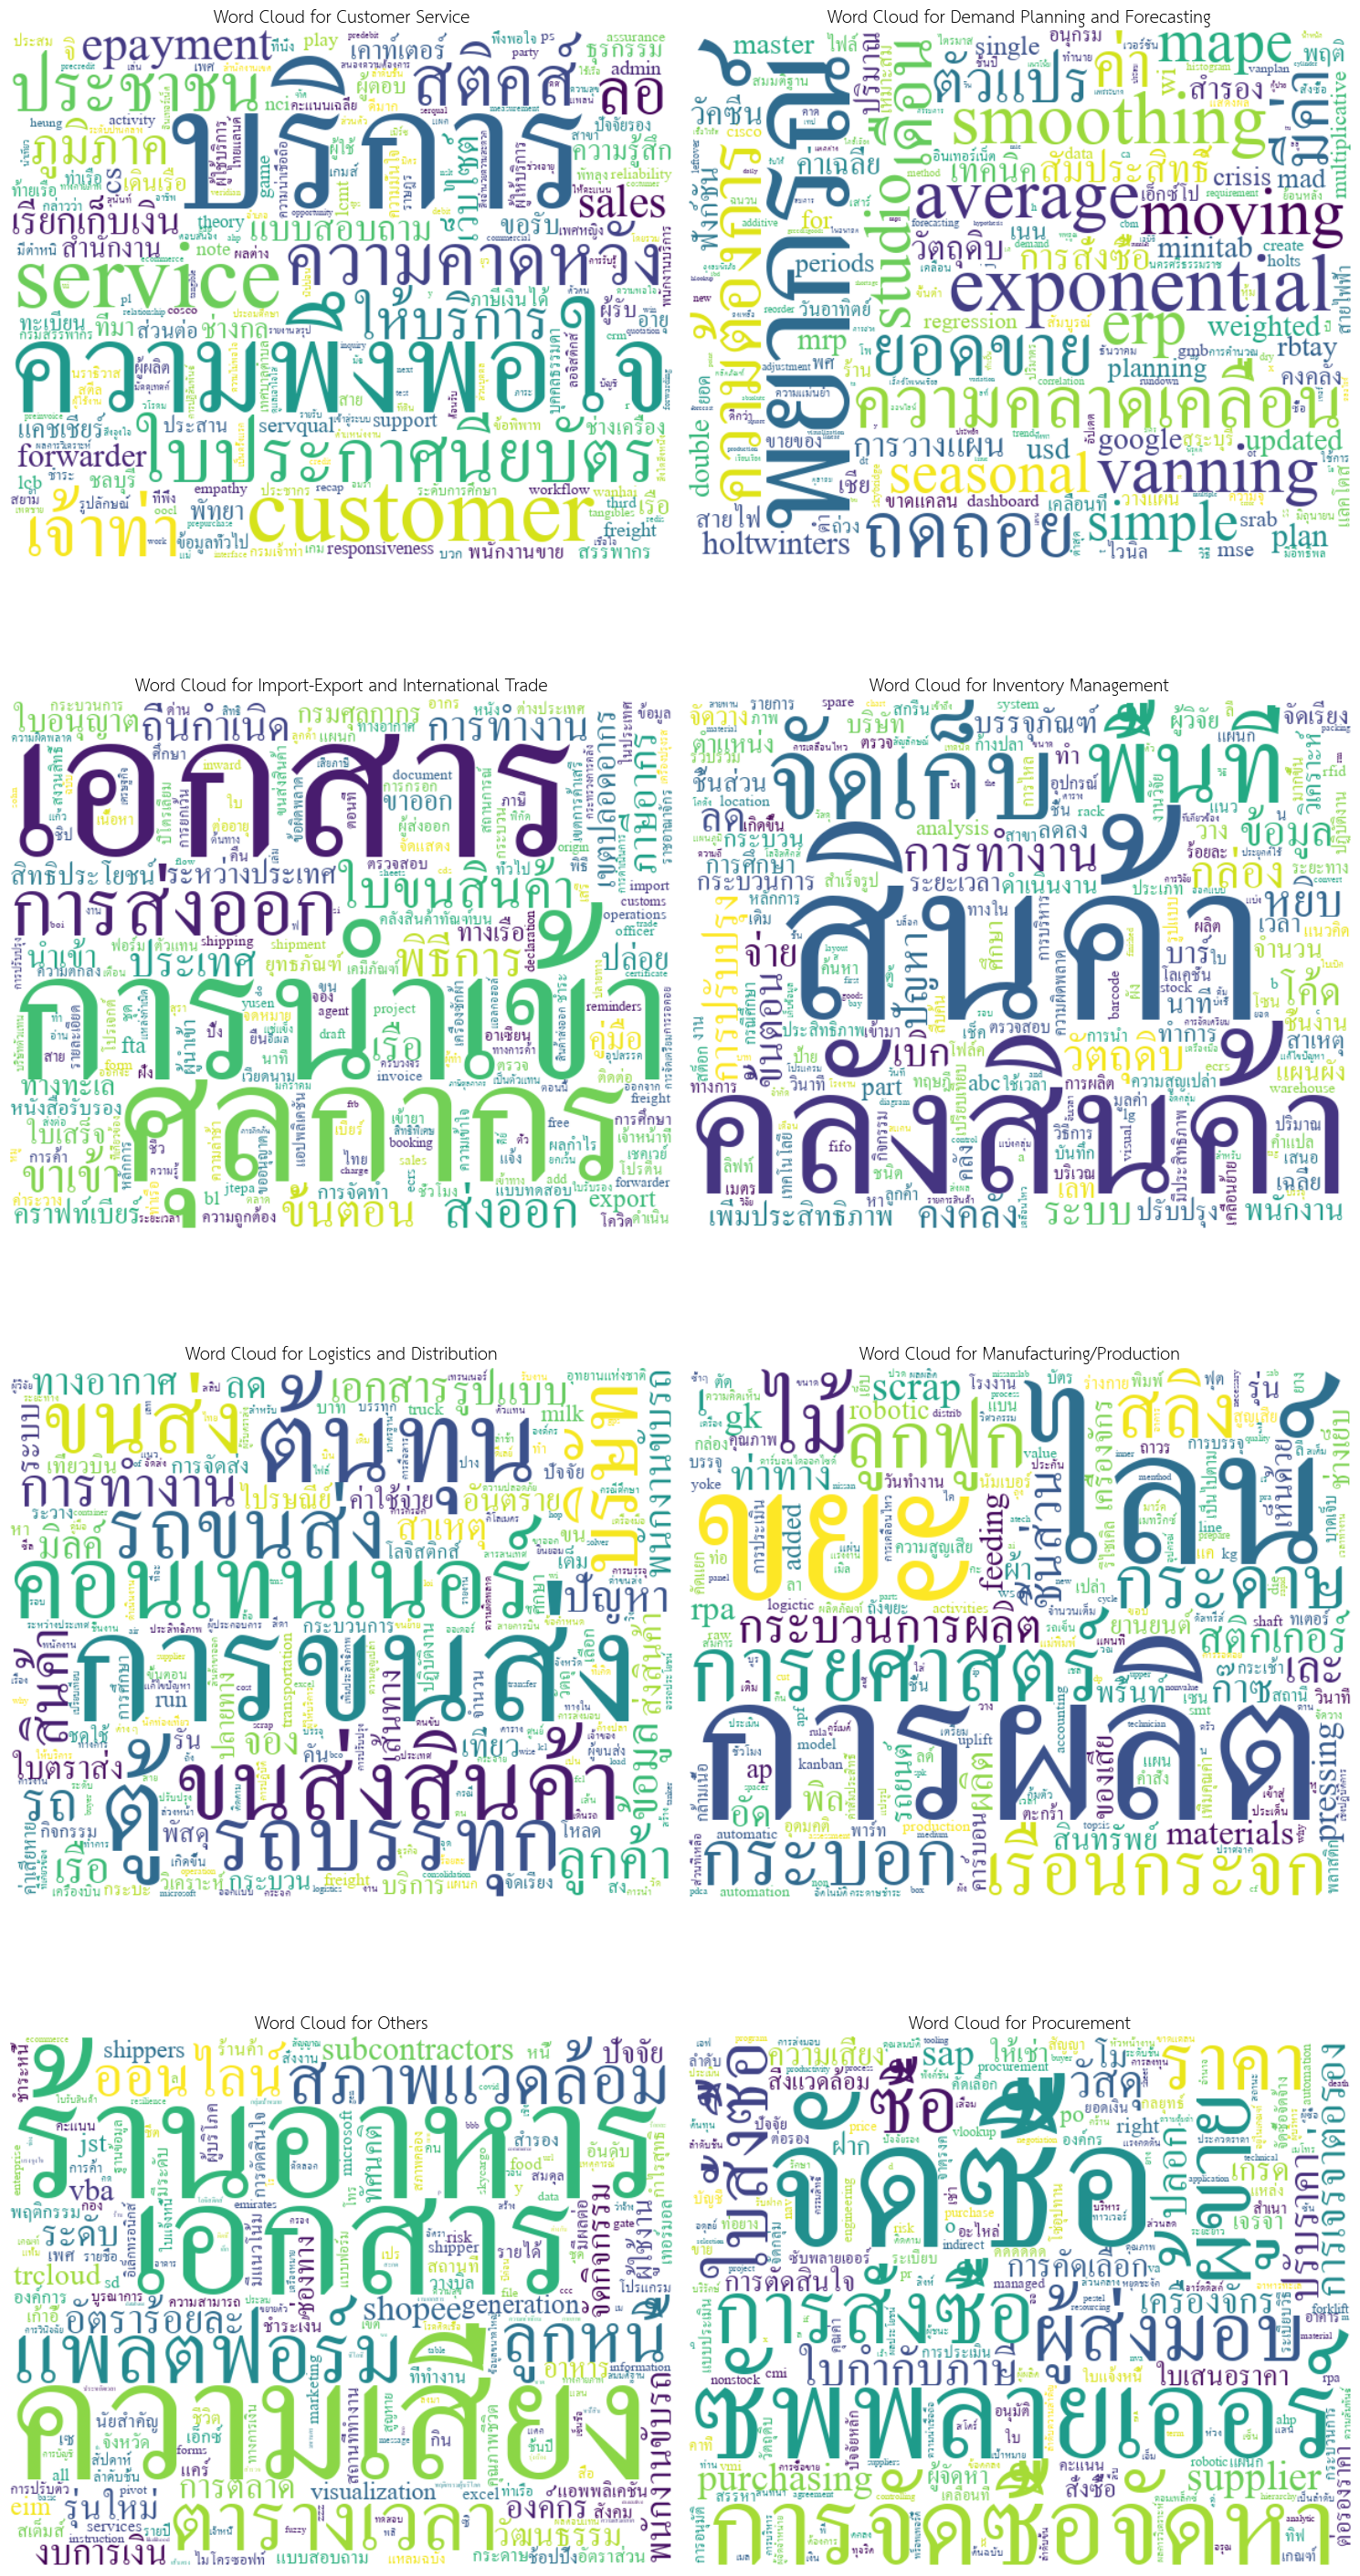

In [159]:
# Path to Thai font (change this path based on where you store the font on your machine)
thai_font_path = 'content/angsana.ttc'

# Create a figure with 4 rows and 2 columns for subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))

# Flatten the 2D axes array to make it easier to iterate
axes = axes.flatten()

# Iterate through the columns of df_with_avg and generate word clouds
for i, col in enumerate(df_with_avg.columns):
    cats = dict(zip(df_with_avg_least.index, df_with_avg_least[col]))
    
    # Generate WordCloud for Thai text
    wordcloud = WordCloud(width=600, 
                          height=480, 
                          background_color='white',
                          font_path=thai_font_path).generate_from_frequencies(cats)
    
    # Plot the word cloud in the corresponding subplot
    ax = axes[i]  # Get the flattened subplot corresponding to the column
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # Hide the axis
    ax.set_title(f'Word Cloud for {col}', fontsize=20)
    
plt.tight_layout()
plt.savefig('../images/cat_wordcloud.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()


In [133]:
for col in df_with_avg.columns:
#    topic_counts = topic_counts.reset_index()
    value = topic_counts[topic_counts['category'] == col]['count'].values[0]
    df_with_avg_least = df_with_avg.copy()
    df_with_avg_least[col] = df_with_avg_least[col]/value


In [143]:
df_with_avg_least['max_value'] = df_with_avg_least.max(axis=1)

df_with_avg_least['max_column'] = df_with_avg_least.idxmax(axis=1)

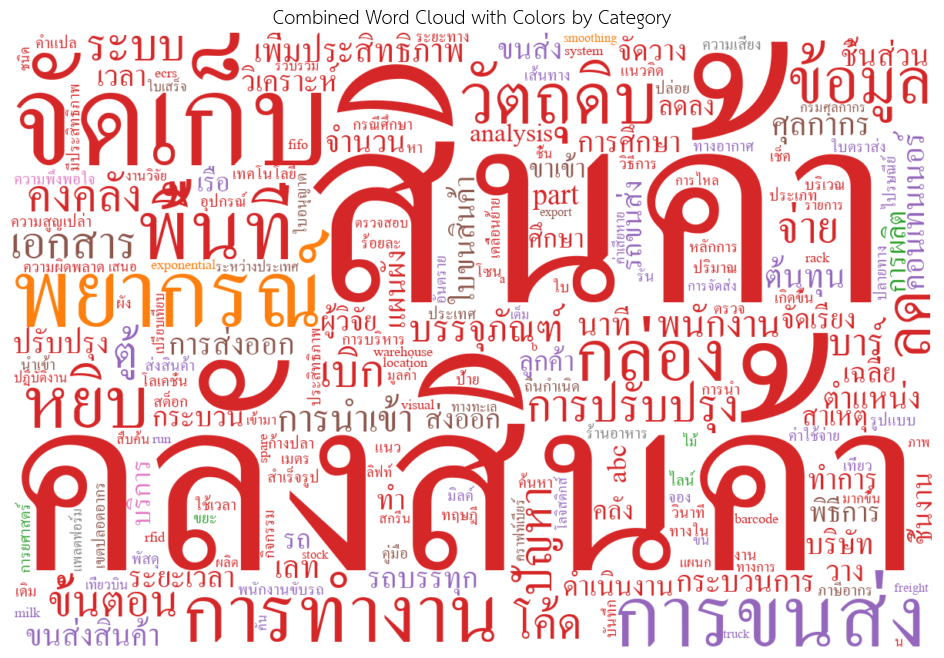

In [161]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Path to Thai font (adjust this to your setup)
thai_font_path = 'content/angsana.ttc'

# Define a color palette for each column
color_palette = {
    'Procurement': '#1f77b4',
    'Demand Planning and Forecasting': '#ff7f0e',
    'Manufacturing/Production': '#2ca02c',
    'Inventory Management': '#d62728',
    'Logistics and Distribution': '#9467bd',
    'Import-Export and International Trade': '#8c564b',
    'Customer Service': '#e377c2',
    'Others': '#7f7f7f',
}

# Prepare word frequencies and colors
combined_frequencies = dict(zip(df_with_avg_least.index, df_with_avg_least['max_value']))
word_colors = dict(zip(df_with_avg_least.index, df_with_avg_least['max_column']))

# Function to assign color based on the max_column
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    category = word_colors.get(word, None)  # Get the category name
    return color_palette.get(category, '#000000')  # Default to black if no match

# Generate the word cloud
wordcloud = WordCloud(width=1200,
                      height=800,
                      background_color='white',
                      font_path=thai_font_path).generate_from_frequencies(combined_frequencies)

# Apply the custom color function
wordcloud.recolor(color_func=color_func)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Combined Word Cloud with Colors by Category', fontsize=20)

# Save the plot (optional)
plt.savefig('../images/wordcloud.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [168]:
top_each_cat = []
for col in df_with_avg.columns:
    top = df_with_avg.sort_values(by = col, ascending =False).head(1)
    top_each_cat +=list(top.index)

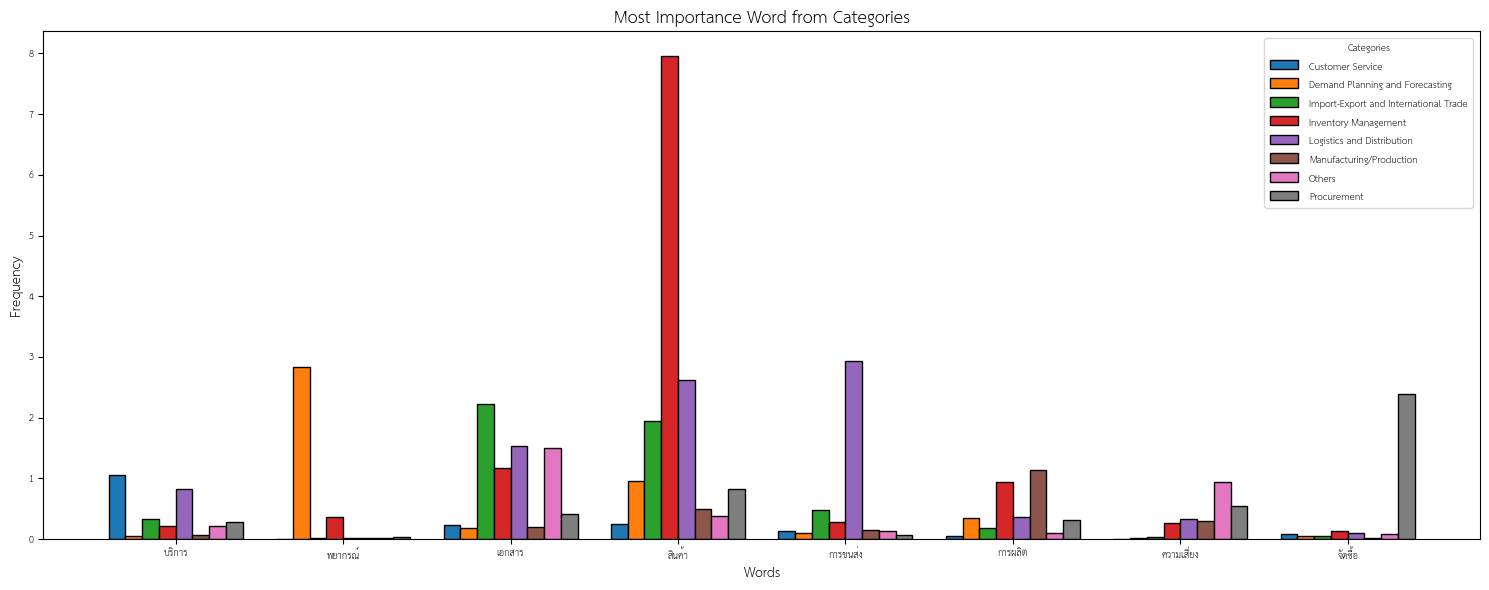

In [166]:
df_stacked = pd.DataFrame(df_X_pc.T, index=top_each_cat)

# Create a figure and axis for the multi-bar chart
fig, ax = plt.subplots(figsize=(15, 6))

# Generate the multi-bar chart
categories = df_stacked.columns
index = df_stacked.index
bar_width = 0.8 / len(categories)  # Width of each bar, adjust based on number of categories
positions = np.arange(len(index))  # X positions for the bars

for i, category in enumerate(categories):
    # Create the bars next to each other
    ax.bar(positions + (i * bar_width), df_stacked[category], width=bar_width, label=category, edgecolor='black')

# Customize the chart
ax.set_title('Most Importance Word from Categories', fontsize=18)
ax.set_xlabel('Words', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xticks(positions + bar_width * (len(categories) - 1) / 2)  # Adjust x-ticks to be in the center
ax.set_xticklabels(index)  # Set the word labels as x-ticks
ax.legend(title='Categories')  # Add legend

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('../images/words_importance.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
